<a href="https://colab.research.google.com/github/abhiramnitin/Dispersion-Trading/blob/main/DispersionTradingStrategyPortfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# importing required libraries

import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [17]:
# downloading historical market data (HIFTY 50) and historical data for selected Indian market stocks

nifty50 = yf.download('^NSEI', start='2014-01-01', end='2024-01-01')
nifty50['Adj Close'] = nifty50['Adj Close'].pct_change().dropna()
nifty50.rename(columns={'Adj Close': 'Market'}, inplace=True)

# Assuming constant risk-free rate (5%) and 252 trading days
risk_free_rate = 0.05 / 252

# Selected list of stock tickers
stock_tickers = ['RELIANCE.NS', 'ONGC.NS', 'INFY.NS', 'TCS.NS', 'HINDUNILVR.NS',
                 'BEL.NS', 'ICICIBANK.NS', 'KOTAKBANK.NS', 'SBIN.NS', 'BHARTIARTL.NS',
                 'ITC.NS', 'ASIANPAINT.NS', 'DMART.NS', 'BAJFINANCE.NS', 'MARUTI.NS',
                 'HCLTECH.NS', 'LT.NS', 'WIPRO.NS', 'AXISBANK.NS', 'ULTRACEMCO.NS',
                 'SUNPHARMA.NS', 'BAJAJFINSV.NS', 'NESTLEIND.NS', 'TITAN.NS']

def download_data(tickers, start_date='2014-01-01', end_date='2024-01-01'):
    data = yf.download(tickers, start=start_date, end=end_date)
    return data['Adj Close']
stock_data = download_data(stock_tickers)
nifty_data = yf.download('^NSEI', start='2014-01-01', end='2024-01-01')['Adj Close']

# Calculate daily returns for the stocks and NIFTY50 index
daily_returns = stock_data.pct_change().dropna()
nifty_returns = nifty_data.pct_change().dropna()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  24 of 24 completed
[*********************100%%**********************]  1 of 1 completed


In [18]:
# Combining stock returns with NIFTY50 returns

combined_data = daily_returns.merge(nifty50[['Market']], left_index=True, right_index=True, how='inner')

# Function to estimate CAPM beta
def estimate_capm_beta(stock_returns, market_returns):
    model = sm.OLS(stock_returns, sm.add_constant(market_returns))
    results = model.fit()
    return results.params[1]  # Beta values

# Apply CAPM to all selected stocks
capm_betas = {}
for ticker in stock_tickers:
    try:
        # Check if the ticker is present in the combined data
        if ticker in combined_data.columns:
            capm_betas[ticker] = estimate_capm_beta(combined_data[ticker], combined_data['Market'])
        else:
            print(f"{ticker} not found in combined data columns.")
    except Exception as e:
        print(f"Error processing {ticker}: {e}")

# Print CAPM betas
print(capm_betas)


{'RELIANCE.NS': 1.1107745713559916, 'ONGC.NS': 0.8794517526377043, 'INFY.NS': 0.826405655107799, 'TCS.NS': 0.680828152381185, 'HINDUNILVR.NS': 0.6208676916552349, 'BEL.NS': 0.9658154449100602, 'ICICIBANK.NS': 1.3433249988857947, 'KOTAKBANK.NS': 1.0397024287974248, 'SBIN.NS': 1.2938595531495258, 'BHARTIARTL.NS': 0.8387351082208389, 'ITC.NS': 0.7257373430347711, 'ASIANPAINT.NS': 0.7335282035995043, 'DMART.NS': 0.760878721616331, 'BAJFINANCE.NS': 1.437857760901603, 'MARUTI.NS': 1.0458134600577873, 'HCLTECH.NS': 0.7301433988417114, 'LT.NS': 1.0463065485264238, 'WIPRO.NS': 0.710653549756022, 'AXISBANK.NS': 1.3702089372213588, 'ULTRACEMCO.NS': 0.9944511814774444, 'SUNPHARMA.NS': 0.6615521404560444, 'BAJAJFINSV.NS': 1.3441866560408944, 'NESTLEIND.NS': 0.538513347098984, 'TITAN.NS': 0.9241336441901792}


In [19]:
# Constructing a portfolio which is optimised under the given constraints

# Define objective function
def objective(weights, betas):
    portfolio_beta = np.dot(weights, list(betas.values()))
    return np.abs(portfolio_beta)

# Define constraints
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Initial weights
initial_weights = [1 / len(stock_tickers)] * len(stock_tickers)

# Optimize portfolio weights
result = minimize(objective, initial_weights, args=(capm_betas,), method='SLSQP', constraints=constraints)

# Get optimized weights
optimized_weights = result.x

# Print optimized weights
print(optimized_weights)


[-0.05729945  0.07887255  0.11009901  0.19579562  0.23109233  0.02803315
 -0.1941941  -0.01546166 -0.16507544  0.10284109  0.16935908  0.16477287
  0.14867252 -0.24984237 -0.01905901  0.16676538 -0.01934928  0.1782384
 -0.21001977  0.01117624  0.20714276 -0.19470132  0.27957157  0.05256981]


In [20]:
# Visualising the minimised beta risk result using Plotly

# Visualize CAPM beta exposures for a selected stock (e.g., TITAN.NS)
if ticker in capm_betas:
    fig = go.Figure(data=[go.Bar(x=['Beta'], y=[capm_betas[ticker]])])
    fig.update_layout(title=f'CAPM Beta for {ticker}', xaxis_title='Factor', yaxis_title='Exposure')
    fig.show()
else:
    print(f"CAPM beta for {ticker} not found.")

# Visualize portfolio weights
fig = go.Figure(data=[go.Bar(x=stock_tickers, y=optimized_weights)])
fig.update_layout(title='Optimized Portfolio Weights', xaxis_title='Stock Ticker', yaxis_title='Weight')
fig.update_xaxes(tickangle=45)
fig.show()


In [21]:
# Performing a simple dispersion trading strategy

# Estimating rolling volatility (as standard deviation) over a period of 30 days

window = 30
stock_volatility = daily_returns.rolling(window=window).std().dropna()
nifty_volatility = nifty_returns.rolling(window=window).std().dropna()


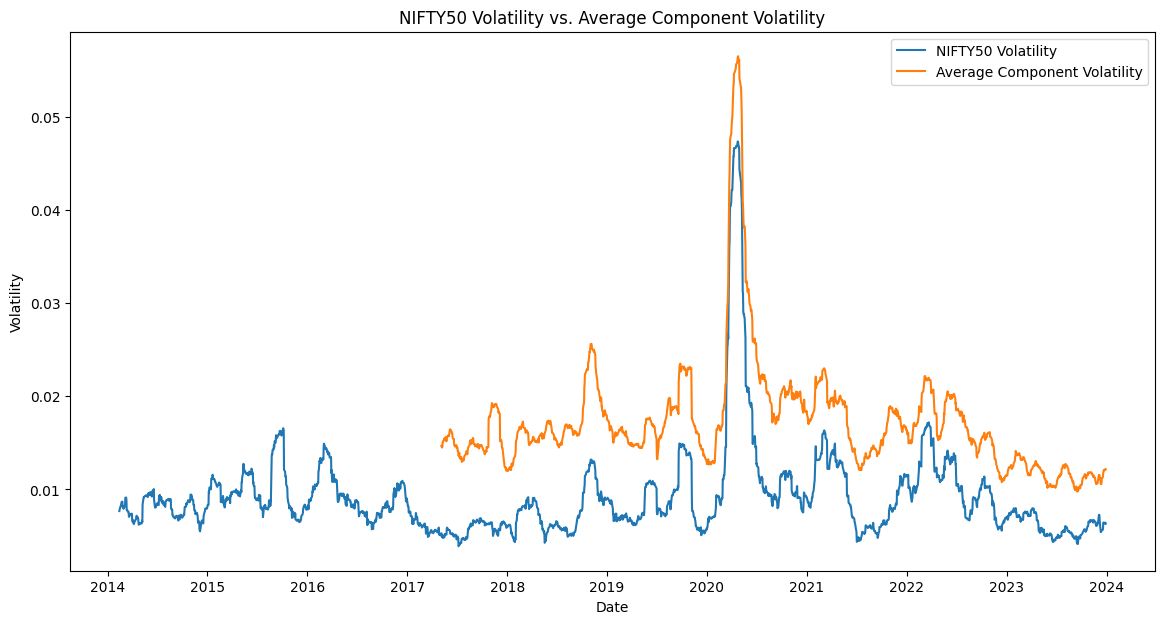

In [22]:
# Comparing Index Volatility with Component Volatility

average_component_volatility = stock_volatility.mean(axis=1)

plt.figure(figsize=(14, 7))
plt.plot(nifty_volatility, label='NIFTY50 Volatility')
plt.plot(average_component_volatility, label='Average Component Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.title('NIFTY50 Volatility vs. Average Component Volatility')
plt.show()


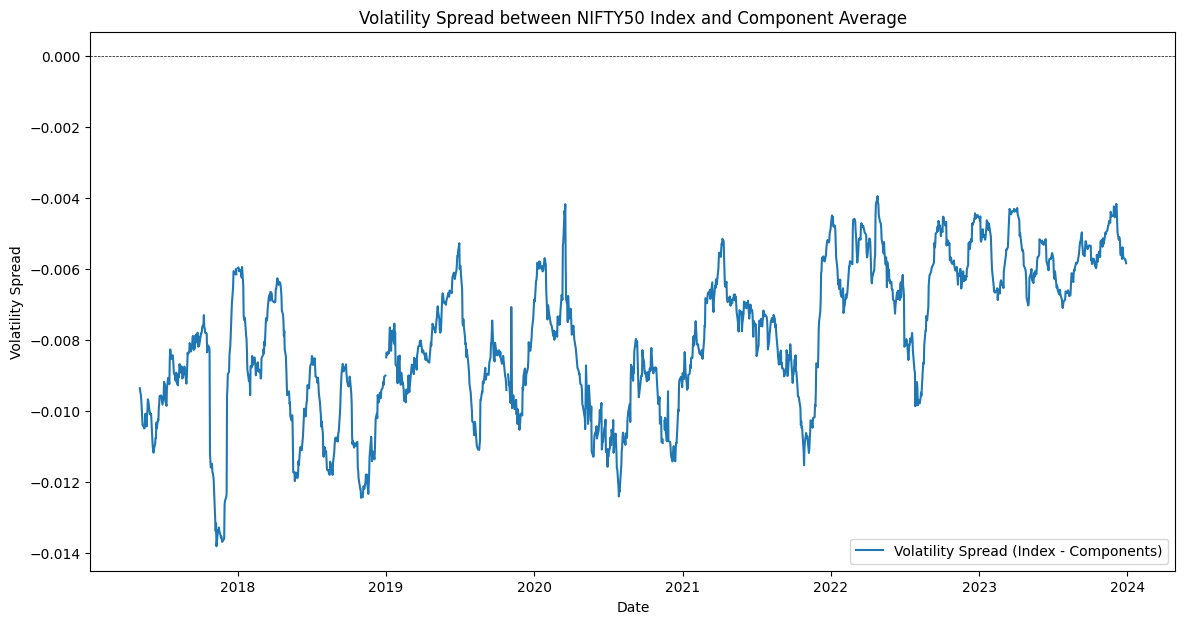

In [27]:
# Volatility Spread
volatility_spread = nifty_volatility - average_component_volatility

plt.figure(figsize=(14, 7))
plt.plot(volatility_spread, label='Volatility Spread (Index - Components)')
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.xlabel('Date')
plt.ylabel('Volatility Spread')
plt.legend()
plt.title('Volatility Spread between NIFTY50 Index and Component Average')
plt.show()

# Implementation of trading logic can involve options/futures strategies and risk management.


In [34]:
# Computing relative performance
def calculate_relative_performance(nifty_returns, daily_returns):
    relative_performance = daily_returns.sub(nifty_returns, axis=0)
    return relative_performance

relative_performance = calculate_relative_performance(nifty_returns, daily_returns)

# Define the trading logic function
def execute_trades_relative_performance(relative_performance):
    trades = []

    # Iterate through each date
    for date, performance in relative_performance.iterrows():
        # Set a threshold for identifying outliers (e.g., 1 standard deviation from the mean)
        threshold = performance.mean() + performance.std()

        # Identify outliers (components with performance beyond the threshold)
        outliers = performance[performance > threshold]

        # Trade on outliers
        for ticker in outliers.index:
            # Assume equal quantities for simplicity
            quantity = 1
            if performance[ticker] > threshold:
                # If the component outperforms the index, short the component and go long on the index
                trades.append((date, 'short', ticker, quantity))
                trades.append((date, 'long', 'NIFTY50', quantity))
            else:
                # If the component underperforms the index, go long on the component and short the index
                trades.append((date, 'long', ticker, quantity))
                trades.append((date, 'short', 'NIFTY50', quantity))

    return trades

# Execute trades based on relative performance
trades_relative_performance = execute_trades_relative_performance(relative_performance)

# Print the trades
for trade in trades_relative_performance:
    print(trade)


Streaming output truncated to the last 5000 lines.
(Timestamp('2017-11-03 00:00:00'), 'short', 'ONGC.NS', 1)
(Timestamp('2017-11-03 00:00:00'), 'long', 'NIFTY50', 1)
(Timestamp('2017-11-03 00:00:00'), 'short', 'SBIN.NS', 1)
(Timestamp('2017-11-03 00:00:00'), 'long', 'NIFTY50', 1)
(Timestamp('2017-11-06 00:00:00'), 'short', 'TITAN.NS', 1)
(Timestamp('2017-11-06 00:00:00'), 'long', 'NIFTY50', 1)
(Timestamp('2017-11-07 00:00:00'), 'short', 'HCLTECH.NS', 1)
(Timestamp('2017-11-07 00:00:00'), 'long', 'NIFTY50', 1)
(Timestamp('2017-11-07 00:00:00'), 'short', 'INFY.NS', 1)
(Timestamp('2017-11-07 00:00:00'), 'long', 'NIFTY50', 1)
(Timestamp('2017-11-07 00:00:00'), 'short', 'NESTLEIND.NS', 1)
(Timestamp('2017-11-07 00:00:00'), 'long', 'NIFTY50', 1)
(Timestamp('2017-11-07 00:00:00'), 'short', 'TCS.NS', 1)
(Timestamp('2017-11-07 00:00:00'), 'long', 'NIFTY50', 1)
(Timestamp('2017-11-08 00:00:00'), 'short', 'ASIANPAINT.NS', 1)
(Timestamp('2017-11-08 00:00:00'), 'long', 'NIFTY50', 1)
(Timestamp('201